In [1]:
import numpy as np
import scipy.linalg as la
from scipy.linalg import eig, qr, block_diag
from numpy.linalg import svd
import control
from scipy.linalg import null_space
import math
import matplotlib.pyplot as plt


def subspace_dist(Phi1,Phi2):
    S_comp = null_space(Phi2.T)
    return la.norm(Phi1.T@S_comp,2)


def zo2p(A, B, Q, R, K, r, ns, gamma):
    dx = A.shape[0]
    du = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((du, dx))
    Ul=[]
    for l in range(ns):
        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))

        K1.append(K + r*U)
        K2.append(K - r*U)

        # Compute cost
        x_0 = np.random.normal(0, 1, size=(1,dx))[0]
        cost_1.append(cost_gamma_x0(A, B, Q, R, K1[-1],gamma,x_0))
        cost_2.append(cost_gamma_x0(A, B, Q, R, K2[-1],gamma,x_0))
        Ul.append(U)

        grad += ((dx * du) / (2 * ns * (r))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def cost_gamma(A, B, Q, R, K, gamma):
        dx = A.shape[0]
        tau = 50
        ns = 100
        cost = 0
        for i in range(ns):
            cost_i = 0
            x = np.random.normal(0, 1, size=(1,dx))[0]
            for t in range(tau):
                u = -K@x
                cost_i += (gamma**t)*(x.T@Q@x + u.T@R@u)
                x = (A-B@K)@x
            cost+=(1/ns)*cost_i  
        
        return cost
    
    
def cost_gamma_x0(A, B, Q, R, K, gamma, x):
        dx = A.shape[0]
        tau = 50
        cost = 0
        for t in range(tau):
            u = -K@x
            cost += (gamma**t)*(x.T@Q@x + u.T@R@u)
            x = (A-B@K)@x
        return cost
    
    
def find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi):
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr = []
    gammas = []
    k = 0
    flag = 0
    k0 = 0
    while gamma<1:
        
        sr.append(max(abs(la.eigvals(A-B@K))))
        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr[-1]}, gamma: {gammas[-1]}")
        K_l = K
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr, gammas

def find_stabilizing_ld(A,B,Q,R,gamma,N,r,ns,eta,Phi,A_hd,B_hd,xi):
    eta0 = eta
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr_ld = []
    sr_hd = []
    gammas = []
    k = 0
    k0 = 0
    flag = 0
    while gamma<1:
        sr_ld.append(max(abs(la.eigvals(A-B@K))))
        sr_hd.append(max(abs(la.eigvals(A_hd-B_hd@K@Phi.T))))

        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr_ld[-1]}, gamma: {gammas[-1]}")
        K_l = K
        #Local updates:
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr_ld, sr_hd, gammas

def simulate_system(A,x):
    return A @ x

def get_basis(A):
    e_i_p = []
    for i in range(dx):
        e_i = np.zeros(dx)
        e_i[i] = 1
        e_i_p.append(simulate_system(A,e_i))
    return e_i_p

def adjoint_data(x0,T,e_i_p):
    dx = x0.shape[0]
    X = np.zeros((dx,T))
    x = x0
    for t in range(T):
        x_adj = np.zeros(dx)
        for i in range(dx):
            x_adj[i] = np.dot(e_i_p[i], x)
        x = x_adj
        X[:,t] = x.reshape(dx,)    
    return X

$\textbf{LTI system:}$

$\textbf{Inverted Pendulum:}$

In [2]:
l = 1 #number of unstable modes
d0 = 2
du = 1

#mp = 1, mc = 1, l = 1
#dt = 0.25, g = 10

dt = 0.25
g = 10
ell = 1
m = 1

A0 = np.array([ [1, dt], [(g/ell)*dt, 1]])
B0 = np.array([  [0],  [dt/(m*(ell**2))]])

In [4]:
nr = 5 #number of realizations

$\textbf{Case 1: (Algorithm 1)}\;\ d_x = 20, \ell = 3$

In [28]:
dx = 20
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 5e-3
xi = 0.9
srs1 = []
gammas1 = []
x = np.ones((dx,1))
for i in range(nr):
    
    #Augmenting the nominal system
    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    #Learning the left unstable subspce
    T = 40 #horizon length
    e_i_p = get_basis(A)
    D = adjoint_data(x,T,e_i_p)
    U,S,V = svd(D)
    Phi_hat = U[:,:l]
    Au = Phi_hat.T@A@Phi_hat
    Bu = Phi_hat.T@B
    Qu = Phi_hat.T@(100*np.eye(dx))@Phi_hat
    R = np.eye(du)
    print(f"Realization: {i}")
    K,_,sr1,gamms = find_stabilizing_ld(Au,Bu,Qu,R,gamma,N,r,ns,eta,Phi_hat,A,B,xi)
    print("-----------------")
    srs1.append(sr1)
    gammas1.append(gamms)

Realization: 0
Iteration: 0, Spectral radius: 1.7905694150420957, gamma: 0.1
Iteration: 1, Spectral radius: 1.7478138437133588, gamma: 0.16061456480002587
Iteration: 2, Spectral radius: 1.6684518357863936, gamma: 0.21842696639705098
Iteration: 3, Spectral radius: 1.554120884433248, gamma: 0.26209078056490476
Iteration: 4, Spectral radius: 1.4188072961251825, gamma: 0.3170750323614603
Iteration: 5, Spectral radius: 1.280809246894293, gamma: 0.4164699548755853
Iteration: 6, Spectral radius: 1.0827700732698213, gamma: 0.5402138433238488
Iteration: 7, Spectral radius: 0.8957477341695804, gamma: 0.7844533256309905
-----------------
Realization: 1
Iteration: 0, Spectral radius: 1.7905694150420957, gamma: 0.1
Iteration: 1, Spectral radius: 1.7507574762727762, gamma: 0.1588974006254164
Iteration: 2, Spectral radius: 1.6742784195641747, gamma: 0.2282571995661001
Iteration: 3, Spectral radius: 1.5357107057091273, gamma: 0.2788309369614727
Iteration: 4, Spectral radius: 1.3791251117350103, gamma:

In [30]:
dimg = 1e10
for i in range(nr):
    dimg = min(len(gammas1[i]),dimg) 
    
dimsr = 1e10
for i in range(nr):
    dimsr = min(len(srs1[i]),dimsr) 


gammas1r = np.zeros((nr,dimg))
sr1s = np.zeros((nr,dimsr))
for i in range(nr):
    gammas1r[i,:] = gammas1[i][:dimg]
    sr1s[i,:] = srs1[i][:dimsr]

$\textbf{Closed-loop spectral radius:}$

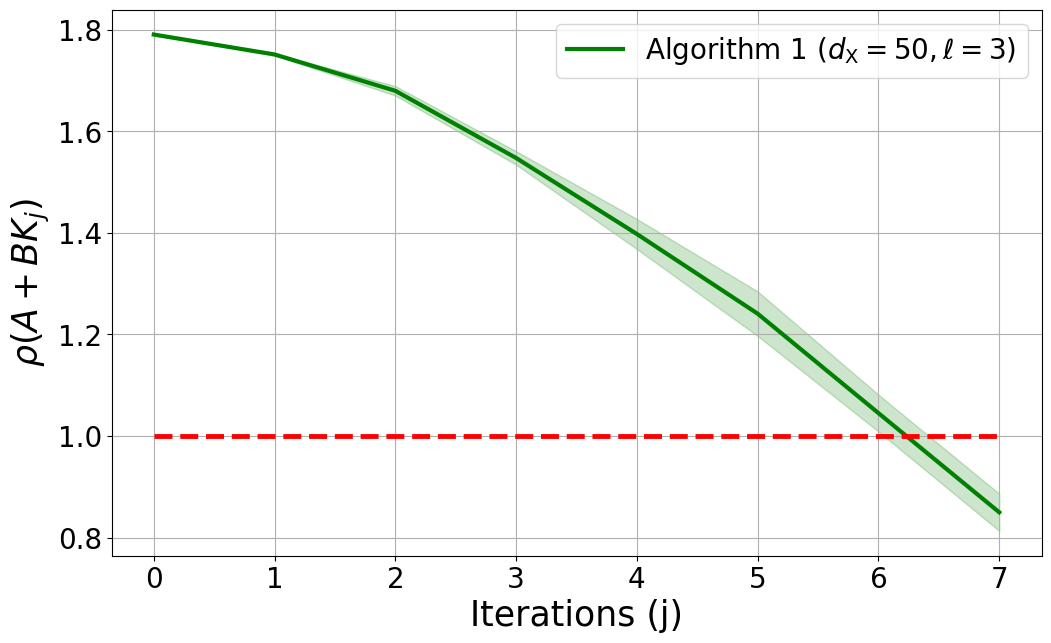

In [31]:
plt.figure(figsize=(12,7))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 50, \ell = 3)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)
plt.plot(np.arange(dimsr), np.ones(dimsr), linestyle='--', color='red', linewidth=3.5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)


plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Discount factor:}$

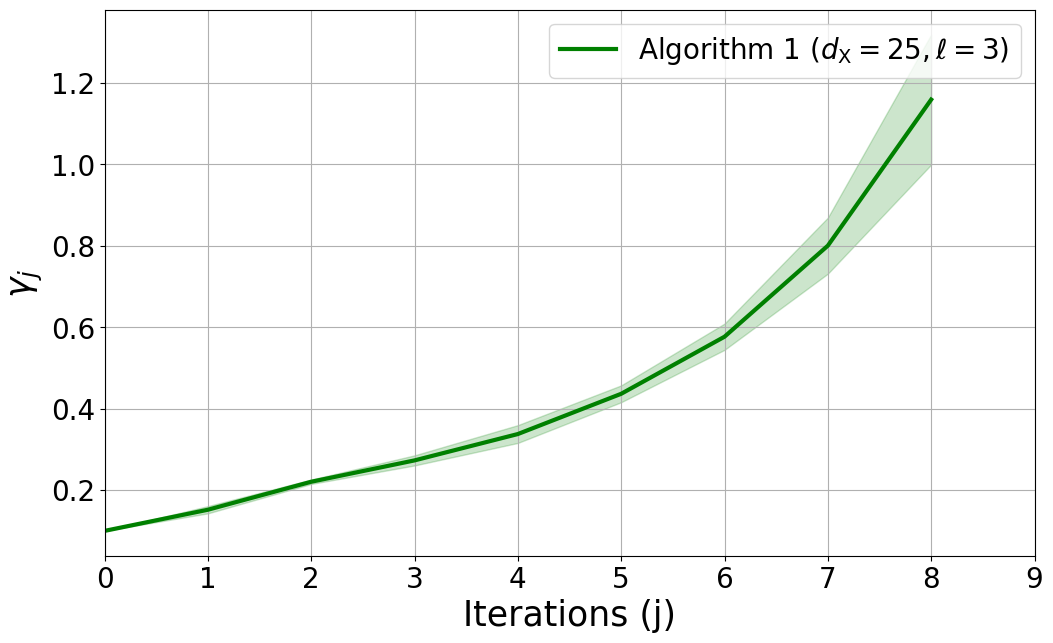

In [32]:
plt.figure(figsize=(12,7))


# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1


plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 25, \ell = 3)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plt.ylabel(r'$\gamma_j$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(0, dimg)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Case 2: (LTS all modes)}\;\ dx = 20, \ell = 3$

In [11]:
dx = 20
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-3
xi = 0.9
srs2 = []
gammas2 = []
for i in range(nr):
    
    #Augmenting the nominal system
    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    Q = 100*np.eye(dx)
    R = np.eye(du)
    
    print(f"Realization: {i}")
    K,sr2,gamms2 = find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi)
    print("-----------------")
    srs2.append(sr2)
    gammas2.append(gamms2)

Realization: 0
Iteration: 0, Spectral radius: 1.790569415042095, gamma: 0.1
Iteration: 1, Spectral radius: 1.7201699395095136, gamma: 0.10220888445149179
Iteration: 2, Spectral radius: 1.6868200774307553, gamma: 0.10444703951186196
Iteration: 3, Spectral radius: 1.6478979709905364, gamma: 0.10670101595993019
Iteration: 4, Spectral radius: 1.615795096365849, gamma: 0.10899415910691689
Iteration: 5, Spectral radius: 1.5802357984088704, gamma: 0.11129065985196875
Iteration: 6, Spectral radius: 1.5617736475360267, gamma: 0.11379095741754704
Iteration: 7, Spectral radius: 1.5365539531640737, gamma: 0.11616363940456317
Iteration: 8, Spectral radius: 1.524262031106295, gamma: 0.11867568147517507
Iteration: 9, Spectral radius: 1.5123015417972836, gamma: 0.12134514391121787
Iteration: 10, Spectral radius: 1.4939147222294133, gamma: 0.12398809395766566
Iteration: 11, Spectral radius: 1.477615582043546, gamma: 0.12678832728934866
Iteration: 12, Spectral radius: 1.4718587356949817, gamma: 0.129588

Iteration: 105, Spectral radius: 0.8375261364242956, gamma: 0.8242013748192484
Iteration: 106, Spectral radius: 0.8315759817344686, gamma: 0.8383276201588294
Iteration: 107, Spectral radius: 0.8225582990806792, gamma: 0.8527487460249339
Iteration: 108, Spectral radius: 0.8128067282456861, gamma: 0.8676499966643597
Iteration: 109, Spectral radius: 0.8014194055685923, gamma: 0.8815849931329881
Iteration: 110, Spectral radius: 0.7950683141071021, gamma: 0.8965772898727434
Iteration: 111, Spectral radius: 0.7815205335928465, gamma: 0.9106594106440096
Iteration: 112, Spectral radius: 0.7742279369704929, gamma: 0.9243172119180229
Iteration: 113, Spectral radius: 0.7718374001138859, gamma: 0.9400261948359787
Iteration: 114, Spectral radius: 0.7576225971660563, gamma: 0.955231404171283
Iteration: 115, Spectral radius: 0.7510740411335173, gamma: 0.9707412266131872
Iteration: 116, Spectral radius: 0.7444277658387174, gamma: 0.9872471256256754
-----------------
Realization: 1
Iteration: 0, Spectr

Iteration: 93, Spectral radius: 0.9379940932712431, gamma: 0.6725857597963397
Iteration: 94, Spectral radius: 0.9323147932074168, gamma: 0.6846708401605397
Iteration: 95, Spectral radius: 0.9252573897033857, gamma: 0.6971125263096053
Iteration: 96, Spectral radius: 0.9140566550136405, gamma: 0.7090741909435319
Iteration: 97, Spectral radius: 0.9059160681348605, gamma: 0.7223718663019739
Iteration: 98, Spectral radius: 0.8992252016864357, gamma: 0.733875168537032
Iteration: 99, Spectral radius: 0.8914641235012356, gamma: 0.7464872991171174
Iteration: 100, Spectral radius: 0.8823209513705231, gamma: 0.7600017474283032
Iteration: 101, Spectral radius: 0.8731152911820655, gamma: 0.7725679780982779
Iteration: 102, Spectral radius: 0.864609958955611, gamma: 0.7865168555384461
Iteration: 103, Spectral radius: 0.8552690061269759, gamma: 0.7995725122998724
Iteration: 104, Spectral radius: 0.8485102106938283, gamma: 0.8136496844999168
Iteration: 105, Spectral radius: 0.8392475933417861, gamma: 0

Iteration: 82, Spectral radius: 1.0199515402895654, gamma: 0.5459940805174488
Iteration: 83, Spectral radius: 1.0126979516456283, gamma: 0.5560770191488698
Iteration: 84, Spectral radius: 1.0057492362591893, gamma: 0.5660396927419326
Iteration: 85, Spectral radius: 0.9993643737862169, gamma: 0.5771262585240353
Iteration: 86, Spectral radius: 0.9926978197177962, gamma: 0.5878643747066697
Iteration: 87, Spectral radius: 0.9862771013399094, gamma: 0.5997792786932028
Iteration: 88, Spectral radius: 0.9801946492893687, gamma: 0.6107598310688547
Iteration: 89, Spectral radius: 0.9730042609775644, gamma: 0.623084494766996
Iteration: 90, Spectral radius: 0.9631107572346591, gamma: 0.6352360036797418
Iteration: 91, Spectral radius: 0.9549645162127154, gamma: 0.6470933364819239
Iteration: 92, Spectral radius: 0.945162982387344, gamma: 0.6588472547108429
Iteration: 93, Spectral radius: 0.9383932321881219, gamma: 0.6706925388390362
Iteration: 94, Spectral radius: 0.9300264358300699, gamma: 0.68282

Iteration: 69, Spectral radius: 1.1027701829888188, gamma: 0.42437851153958966
Iteration: 70, Spectral radius: 1.0965595006900424, gamma: 0.4328585813304663
Iteration: 71, Spectral radius: 1.0909753410613474, gamma: 0.44143272103906955
Iteration: 72, Spectral radius: 1.0859457433279682, gamma: 0.4499647090613879
Iteration: 73, Spectral radius: 1.0807121108271365, gamma: 0.45881422892115153
Iteration: 74, Spectral radius: 1.0736815904073707, gamma: 0.46823986701402587
Iteration: 75, Spectral radius: 1.067047425689163, gamma: 0.477586349652411
Iteration: 76, Spectral radius: 1.0609608801258257, gamma: 0.48616896247576685
Iteration: 77, Spectral radius: 1.0544917394630673, gamma: 0.4958033025539249
Iteration: 78, Spectral radius: 1.0476202720623387, gamma: 0.5046546056155472
Iteration: 79, Spectral radius: 1.042252064636887, gamma: 0.5143786191924267
Iteration: 80, Spectral radius: 1.0366487384310412, gamma: 0.5240562748216253
Iteration: 81, Spectral radius: 1.0293605650149582, gamma: 0.5

Iteration: 57, Spectral radius: 1.166125432100452, gamma: 0.3373612287825595
Iteration: 58, Spectral radius: 1.1588650168589, gamma: 0.34446642984537096
Iteration: 59, Spectral radius: 1.1520885696109655, gamma: 0.3516921711626039
Iteration: 60, Spectral radius: 1.1464215575867964, gamma: 0.3590894117295485
Iteration: 61, Spectral radius: 1.139342808976922, gamma: 0.3662435144835168
Iteration: 62, Spectral radius: 1.1333203351640773, gamma: 0.37350409626719516
Iteration: 63, Spectral radius: 1.1279917170476832, gamma: 0.3810090815840026
Iteration: 64, Spectral radius: 1.1210012897715886, gamma: 0.3887207326061958
Iteration: 65, Spectral radius: 1.1164544117037045, gamma: 0.3967085014688992
Iteration: 66, Spectral radius: 1.1101878542702237, gamma: 0.40479754174418775
Iteration: 67, Spectral radius: 1.1053683890066002, gamma: 0.41257318731748877
Iteration: 68, Spectral radius: 1.1015594228860648, gamma: 0.42052790124170114
Iteration: 69, Spectral radius: 1.094676666520748, gamma: 0.4295

In [12]:
dim2g = 1e10
for i in range(nr):
    dim2g = min(len(gammas2[i]),dim2g)
    
dim2sr = 1e10
for i in range(nr):
    dim2sr = min(len(srs2[i]),dim2sr)


gammas2r = np.zeros((nr,dim2g))
sr2s = np.zeros((nr,dim2sr))
for i in range(nr):
    gammas2r[i,:] = gammas2[i][:dim2g]
    sr2s[i,:] = srs2[i][:dim2sr]

$\textbf{Case 3: (LTS all modes)}\;\ dx = 10, \ell = 3$

In [13]:
dx = 10
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-3
xi = 0.9
srs3 = []
gammas3 = []
for i in range(nr):

    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    Q = 100*np.eye(dx)
    R = np.eye(du)
    print(f"Realization: {i}")
    K,sr3,gamms3 = find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi)
    print("-----------------")
    srs3.append(sr3)
    gammas3.append(gamms3)

Realization: 0
Iteration: 0, Spectral radius: 1.790569415042095, gamma: 0.1
Iteration: 1, Spectral radius: 1.732681609989185, gamma: 0.10429831389985811
Iteration: 2, Spectral radius: 1.6851195589932066, gamma: 0.10867365474410201
Iteration: 3, Spectral radius: 1.6518170948260038, gamma: 0.11323283726789711
Iteration: 4, Spectral radius: 1.6207669652057572, gamma: 0.11813918011653098
Iteration: 5, Spectral radius: 1.601876188783237, gamma: 0.123113488889684
Iteration: 6, Spectral radius: 1.5701859745147686, gamma: 0.12833487990549428
Iteration: 7, Spectral radius: 1.543652130466076, gamma: 0.1334840656054566
Iteration: 8, Spectral radius: 1.5155434423033278, gamma: 0.13935373837954362
Iteration: 9, Spectral radius: 1.4935095047653806, gamma: 0.1451660639272614
Iteration: 10, Spectral radius: 1.4690568112101077, gamma: 0.1506935344702719
Iteration: 11, Spectral radius: 1.4522554261851424, gamma: 0.1571613344034073
Iteration: 12, Spectral radius: 1.4328727321237555, gamma: 0.164293651845

Iteration: 40, Spectral radius: 1.0792873638302618, gamma: 0.4684118045015208
Iteration: 41, Spectral radius: 1.0681484253501994, gamma: 0.48547478295779506
Iteration: 42, Spectral radius: 1.0548156017868626, gamma: 0.5021231858174899
Iteration: 43, Spectral radius: 1.041762194890406, gamma: 0.5206458198648131
Iteration: 44, Spectral radius: 1.0293868427871233, gamma: 0.539033810355321
Iteration: 45, Spectral radius: 1.0120746633816617, gamma: 0.5568791242330582
Iteration: 46, Spectral radius: 0.9992038379681057, gamma: 0.5748540949022525
Iteration: 47, Spectral radius: 0.9862176759501082, gamma: 0.5942443093245021
Iteration: 48, Spectral radius: 0.9734164131185946, gamma: 0.6124909843280811
Iteration: 49, Spectral radius: 0.9583956194994603, gamma: 0.6318555509536724
Iteration: 50, Spectral radius: 0.9469898054166179, gamma: 0.6508304128566136
Iteration: 51, Spectral radius: 0.9359209665550484, gamma: 0.6702261137405775
Iteration: 52, Spectral radius: 0.9223292270026542, gamma: 0.6879

Iteration: 13, Spectral radius: 1.4102632390946837, gamma: 0.16982197320206105
Iteration: 14, Spectral radius: 1.3934658075063342, gamma: 0.17703733542891725
Iteration: 15, Spectral radius: 1.3799518320263933, gamma: 0.1837895291460975
Iteration: 16, Spectral radius: 1.3629075091337262, gamma: 0.1914052009471015
Iteration: 17, Spectral radius: 1.3461927600985666, gamma: 0.19917947487775015
Iteration: 18, Spectral radius: 1.332189547708718, gamma: 0.20750770334400756
Iteration: 19, Spectral radius: 1.3218017073416823, gamma: 0.21625047460891994
Iteration: 20, Spectral radius: 1.308269236061606, gamma: 0.22558085745687248
Iteration: 21, Spectral radius: 1.2964626795773722, gamma: 0.23471983880687106
Iteration: 22, Spectral radius: 1.2827670212804327, gamma: 0.24424639220980165
Iteration: 23, Spectral radius: 1.2697426747995197, gamma: 0.2556192723359887
Iteration: 24, Spectral radius: 1.2593597447598013, gamma: 0.26504852285081326
Iteration: 25, Spectral radius: 1.2454176405782071, gamma

Iteration: 56, Spectral radius: 0.8513153299018028, gamma: 0.7954204312307389
Iteration: 57, Spectral radius: 0.8369850095382918, gamma: 0.8151714758755597
Iteration: 58, Spectral radius: 0.8233998945330213, gamma: 0.8354960736333235
Iteration: 59, Spectral radius: 0.8135154516675945, gamma: 0.8573702481810103
Iteration: 60, Spectral radius: 0.8036683655875563, gamma: 0.8797640928050159
Iteration: 61, Spectral radius: 0.7878657773733151, gamma: 0.9013868002075206
Iteration: 62, Spectral radius: 0.7770090243554626, gamma: 0.9219328132061869
Iteration: 63, Spectral radius: 0.7614588470434424, gamma: 0.9443104994144114
Iteration: 64, Spectral radius: 0.7516005421270496, gamma: 0.9638567504188421
Iteration: 65, Spectral radius: 0.7384841260301592, gamma: 0.9881880979134484
-----------------


In [14]:
dim3g = 1e10
for i in range(nr):
    dim3g = min(len(gammas3[i]),dim3g)
    
dim3sr = 1e10
for i in range(nr):
    dim3sr = min(len(srs3[i]),dim3sr)


gammas3r = np.zeros((nr,dim3g))
sr3s = np.zeros((nr,dim3sr))
for i in range(nr):
    gammas3r[i,:] = gammas3[i][:dim3g]
    sr3s[i,:] = srs3[i][:dim3sr]

$\textbf{Closed-loop spectral radius:}$

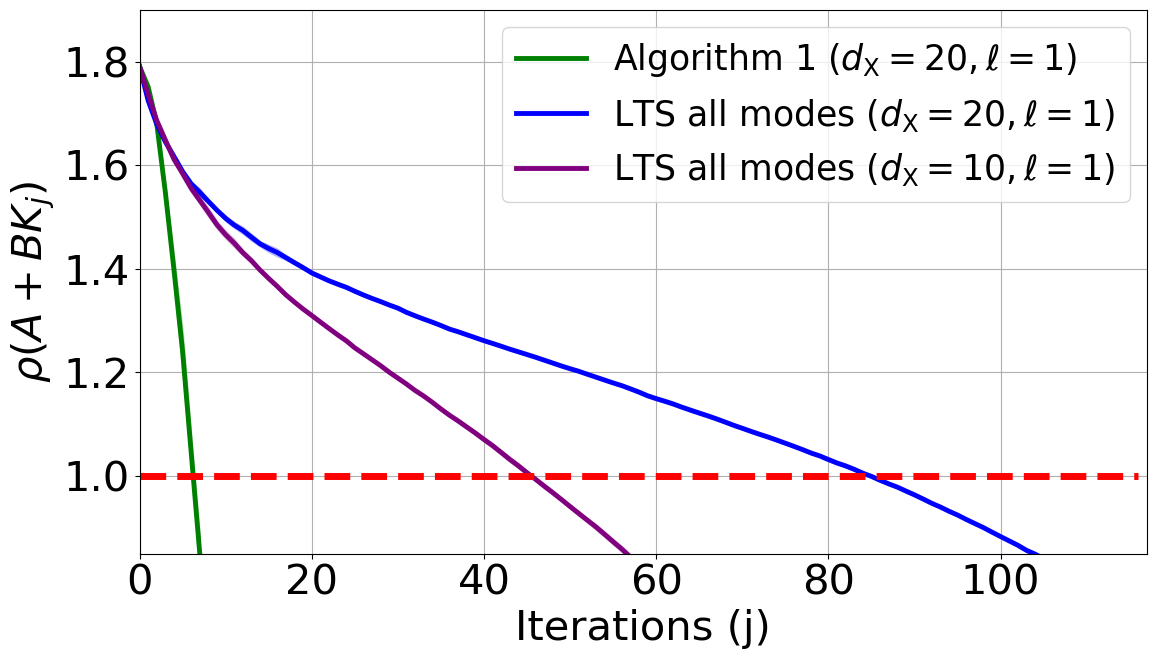

In [34]:
plt.figure(figsize=(13,8))


# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_3 = np.mean(sr3s, axis=0)
sem_3 = np.std(sr3s, axis=0) / np.sqrt(sr3s.shape[0])

# Calculate 95% confidence intervals
ci_3 = 1.95*sem_3


plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20, \ell = 1)$', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes $(d_{\mathsf{X}} = 20, \ell = 1)$', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)

plot_3=plt.plot(np.arange(len(mean_3)), mean_3, label=r'LTS all modes $(d_{\mathsf{X}} = 10, \ell = 1)$', color='purple', linewidth=3.5)
fill_3=plt.fill_between(np.arange(len(mean_3)), mean_3-ci_3, mean_3+ci_3, color='purple', alpha=0.2)

plt.plot(np.arange(dim2sr), np.ones(dim2sr), linestyle='--', color='red', linewidth=5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, dim2sr)
plt.ylim(0.85, 1.9)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3]  
labels = labels[:3]
plt.legend(handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("spectral_radius_inverted_pendulm.pdf")

$\textbf{Discount factor:}$

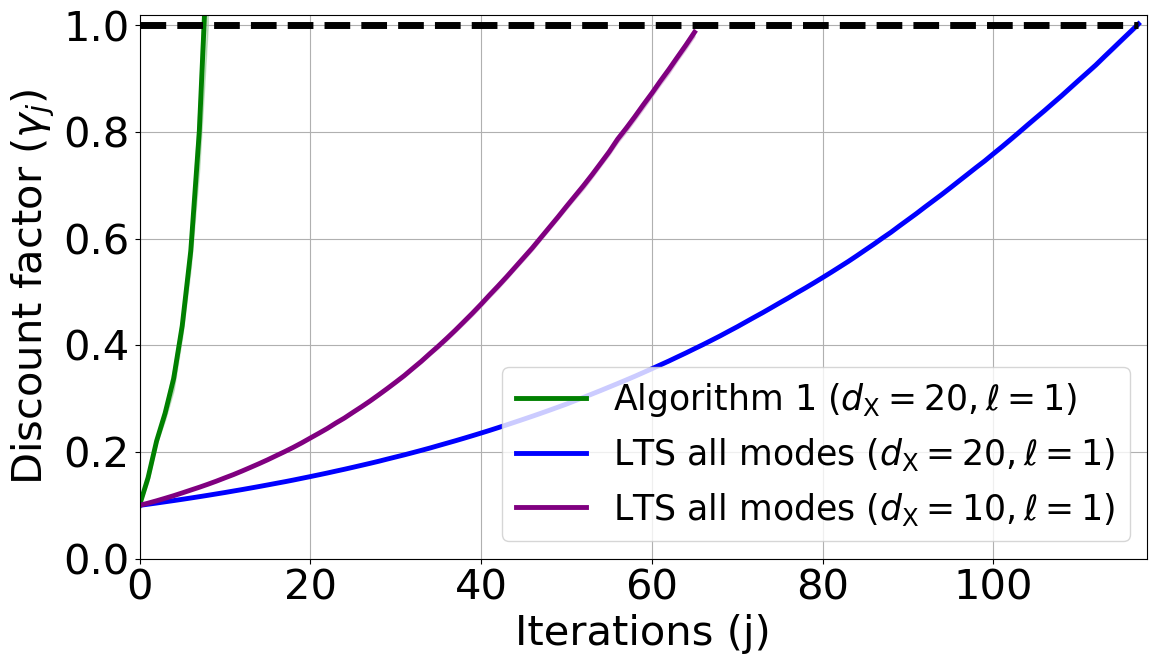

In [36]:
plt.figure(figsize=(13,8))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(gammas2r, axis=0)
sem_2 = np.std(gammas2r, axis=0) / np.sqrt(gammas2r.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_3 = np.mean(gammas3r, axis=0)
sem_3 = np.std(gammas3r, axis=0) / np.sqrt(gammas3r.shape[0])

# Calculate 95% confidence intervals
ci_3 = 1.95*sem_3

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20, \ell = 1)$', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes $(d_{\mathsf{X}} = 20, \ell = 1)$', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)

plot_3=plt.plot(np.arange(len(mean_3)), mean_3, label=r'LTS all modes $(d_{\mathsf{X}} = 10, \ell = 1)$', color='purple', linewidth=3.5)
fill_3=plt.fill_between(np.arange(len(mean_3)), mean_3-ci_3, mean_3+ci_3, color='purple', alpha=0.2)

plt.plot(np.arange(dim2g), np.ones(dim2g), linestyle='--', color='black', linewidth=5)

plt.ylabel(r'Discount factor $(\gamma_j)$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, dim2g)
plt.ylim(0, 1.02)

plt.legend(loc='lower right', fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3] 
labels = labels[:3]
plt.legend(loc='lower right',handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("gamma_inverted_pendulm.pdf")